In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy.stats import *
import operator
from core_functions import *
from statsmodels.stats.multitest import multipletests
import random 

plt.rcParams["font.family"] = "Arial"
plt.rcParams['svg.fonttype'] = 'none'

data_path = '../../data/'
SCdata_path = '../../tmp/scRNAseqdata/'

### Select the tumor cohort to perform the analyses on 

In [2]:
cohort = dropdown_dataset()
display(cohort)

Dropdown(description='Cohort:', options=('tumor+csf', 'tumor'), value='tumor+csf')

Data files loaded have been generated in scRNAseq_tumorIntegrated.R (tumor) or in scRNAseq_tumorCSFIntegrated.R (tumor+CSF)

In [5]:
data_filenames = {'tumor':'allTUMORintegrated','tumor+csf':'allTUMORCSFintegrated'}
if cohort.value == 'tumor':
    SC = pd.read_excel(data_path+'Table S1.xlsx',sheet_name='G')
else:
    SC = pd.read_excel(data_path+'Table S1.xlsx',sheet_name='H')

# Generation of UMAP plots

### Select the cell subset to work on: all cells pooled together (all), Tcell+NK cells (TcellNK) or proliferating leukocytes (PROLIF)

In [3]:
subset = dropdown_subset()
display(subset)

Dropdown(description='Cell subset:', index=1, options=('all', 'TcellNK', 'PROLIF'), value='TcellNK')

In [5]:
csf = False
addplots = False
if subset.value == 'all':
    addplots = True
if cohort.value == 'tumor+csf':
    csf = True

In [11]:
# File generated in scRNAseq_tumorIntegrated.R/scRNAseq_tumorCSFIntegrated.R (dafilaname_subsetname_CLUSTERdist_toannotate.tsv) and thereafter modifified with cluster names and colors, has been included in data/
cluster_annotations = pd.read_csv(SCdata_path+data_filenames[cohort.value]+'_CLUSTERSannotations.csv',sep='\t',index_col=False)

#File generated in scRNAseq_tumorIntegrated.R/scRNAseq_tumorCSFIntegrated.R
umap_values = pd.read_csv(SCdata_path+data_filenames[cohort.value]+'_'+subset.value+'_UMAPvalues.tsv',sep='\t').reset_index()

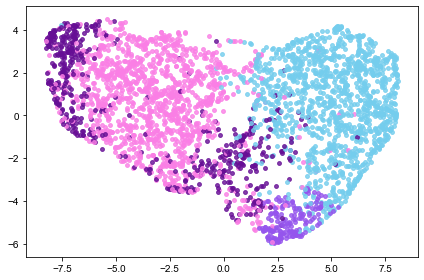

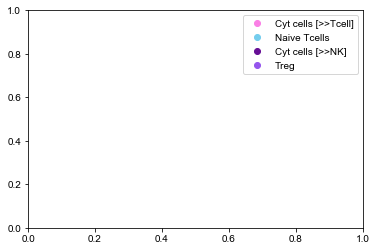

In [12]:
cell_groupdf = cluster_annotations[cluster_annotations['cell_group']==subset.value]
allcolors_clusters = {str(row['cluster_cell_class']):row['color'] for row in cell_groupdf.to_dict(orient='records')}
allzorder_clusters = {str(row['cluster_cell_class']):row['zorder'] for row in cell_groupdf.to_dict(orient='records')}

if subset.value == 'all':
    cell_color = {}
    cell_zorder = {}
    cell_annot = SC
    for row in cell_annot.to_dict(orient='records'):
        if row['cluster_cell_class'] in cell_groupdf.cluster_cell_class.unique():
            cell_color[row['Cell ID']] = allcolors_clusters[row['cluster_cell_class']]
            cell_zorder[row['Cell ID']] = allzorder_clusters[row['cluster_cell_class']]
        else:
            cell_color[row['Cell ID']] = '#8c8c8c'
            cell_zorder[row['Cell ID']] = 1
else:
    cell_annot = SC[SC['Cell clustering group']==subset.value]
    cell_color = {row['Cell ID']:allcolors_clusters[row['cluster_cell_class']] for row in cell_annot.to_dict(orient='records')}
    cell_zorder = {row['Cell ID']:allzorder_clusters[row['cluster_cell_class']] for row in cell_annot.to_dict(orient='records')}

# UMAP colored by cell annotation, as shown in main figure
for row in umap_values.to_dict(orient='records'):                
    plt.scatter(float(row['UMAP_1']),float(row['UMAP_2']),color=cell_color[row['index']],
                zorder=cell_zorder[row['index']],s=15,alpha=0.8)
plt.tight_layout()
plt.show()

fig,ax = plt.subplots()
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in allcolors_clusters.values()]
plt.legend(markers, allcolors_clusters.keys(), numpoints=1)
plt.show()

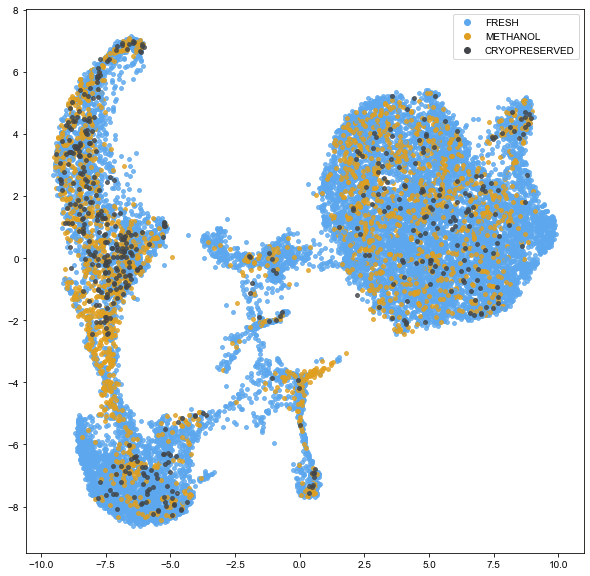

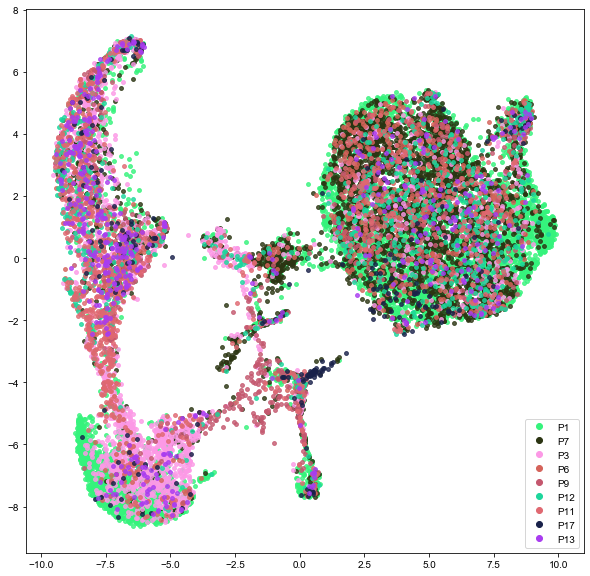

In [62]:
tech_colors = {'FRESH':'#5CA7ED','METHANOL':'#E09F1F','CRYOPRESERVED':'#42464A'}
samples_l = cell_annot['Patient ID'].unique().tolist()
number_of_colors = len(samples_l)
sample_colors = {list(samples_l)[i]:"#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)}
sampletype_colors = {'TUMOR':'#B9B9B8','CSF':'#005C70','CSF_t1':'#28c1df','CSF_t2':'#28c1df'}

if addplots: #Plot additional UMAP from Extended data
    # Colored by sample preservation technique
    cell_tech = {row['Cell ID']:row['Sample preservation'] for row in cell_annot.to_dict(orient='records')} 
    fig,ax = plt.subplots(figsize=(10, 10))
    for row in umap_values.to_dict(orient='records'):
        plt.scatter(float(row['UMAP_1']),float(row['UMAP_2']),color=tech_colors[cell_tech[row['index']]],s=15,alpha=0.8)
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in tech_colors.values()]
    plt.legend(markers, tech_colors.keys(), numpoints=1) 
    plt.show()    

    #Colored by patient sample
    cell_sample = {row['Cell ID']:row['Patient ID'] for row in cell_annot.to_dict(orient='records')}
    fig,ax = plt.subplots(figsize=(10, 10))
    for row in umap_values.to_dict(orient='records'):
        plt.scatter(float(row['UMAP_1']),float(row['UMAP_2']),color=sample_colors[cell_sample[row['index']]],s=15,alpha=0.8)
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in sample_colors.values()]
    plt.legend(markers, sample_colors.keys(), numpoints=1) 
    plt.show()    

if csf: 
    # Colored by sample type
    cell_type = {row['Cell ID']:row['Sample type timepoint'] for row in cell_annot.to_dict(orient='records')} 
    fig,ax = plt.subplots(figsize=(10, 10))
    for row in umap_values.to_dict(orient='records'):
        plt.scatter(float(row['UMAP_1']),float(row['UMAP_2']),color=sampletype_colors[cell_type[row['index']]],s=15,alpha=0.8)
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in cell_type.values()]
    plt.legend(markers, cell_type.keys(), numpoints=1) 
    plt.show()        

# Check cell cycle scores across clusters

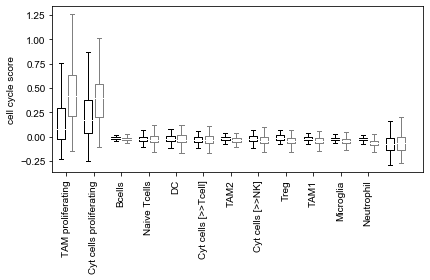

>>> S Score
MannWhitneyU test  Cyt cells proliferating FC= 0.2299947536682923 P-value= 1.1713178304273332e-50
MannWhitneyU test  TAM proliferating FC= 0.1597802224054361 P-value= 7.058874561658017e-44
>>> G2M Score
MannWhitneyU test  Cyt cells proliferating FC= 0.4092953350517303 P-value= 1.9415873327693732e-107
MannWhitneyU test  TAM proliferating FC= 0.45683053549925823 P-value= 6.180710818907717e-195


In [9]:
clusters_sorted = {k: v for k, v in sorted({cluster:np.median(clusterdf['G2M Score']) 
                                            for cluster, clusterdf in SC.groupby('cluster_cell_class')}.items(), key=lambda item: item[1], reverse=True)}
data = [SC[SC['cluster_cell_class']==cluster]['S Score'].tolist() for cluster in clusters_sorted]
data2 = [SC[SC['cluster_cell_class']==cluster]['G2M Score'].tolist()  for cluster in clusters_sorted]
bpl = plt.boxplot(data, positions=np.array(range(0,len(data)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(data2, positions=np.array(range(0,len(data2)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, 'black') 
set_box_color(bpr, 'grey')
plt.xticks(range(0,24,2), clusters_sorted, rotation=90)
plt.xlim(-1,len(clusters_sorted)*2)
#plt.ylim(-0.5,1.5)
plt.ylabel('cell cycle score')
plt.tight_layout()
plt.show()

for score in ['S Score','G2M Score']:
    print('>>>',score)
    for cluster,clusterdf in SC.groupby('cluster_cell_class'):
            x = clusterdf[score]
            y = SC[SC['cluster_cell_class']!=cluster][score]
            U,p = mannwhitneyu(x,y)
            fc = np.mean(x)-float(np.mean(y))
            if p < 0.05 and fc > 0.1:
                print('MannWhitneyU test ',cluster,'FC=',fc,'P-value=',p)

# Cell distribution across samples heatmap + proportion bar plot

### sample proportion heatmap 

In [101]:
merged_cellpops = {
    'Cyt cells':['Cyt cells [>>Tcell]','Cyt cells [>>NK]','Cyt cells [Tcell+NK]'],
    'TAMs':['TAM1','TAM2','TAM'],
    'Bcell':['Bcells1','Bcells2','Bcells']
}
allrepes = [vv for v in merged_cellpops.values() for vv in v]


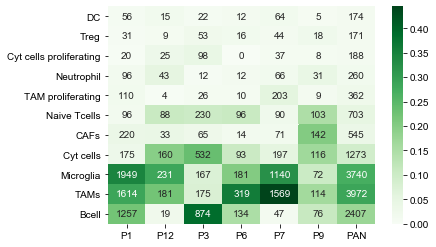

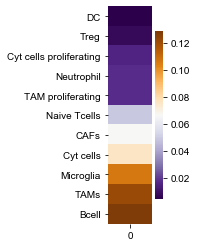

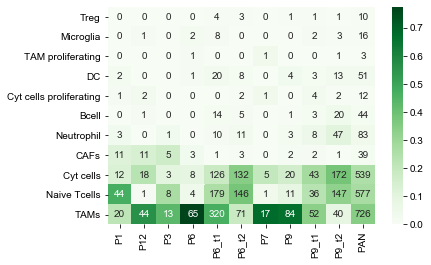

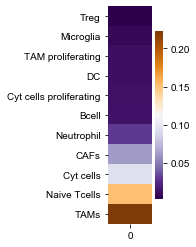

In [102]:
for typ in ['TUMOR','CSF']:
    sampletypedf = SC[SC['Sample type']==typ]
    allcell = []
    allcellp = []
    labels = []
    for patient, patientdf in sampletypedf.groupby('Patient ID'):
        d = {}
        dp = {}
        totpat = len(patientdf)
        for cell in sampletypedf.cluster_cell_class.unique():
            celltypdf  = patientdf[patientdf['cluster_cell_class'] == cell]
            d[cell] = len(celltypdf)
            dp[cell] = len(celltypdf)/float(totpat)
        
        allcell.append(d)
        allcellp.append(dp)
        labels.append(patient)
    d = {}
    dp = {}
    for cell,celltypdf in sampletypedf.groupby('cluster_cell_class'):
        d[cell] = len(celltypdf)
        dp[cell] = len(celltypdf)/float(len(sampletypedf))
    labels.append('PAN')
    allcell.append(d)
    allcellp.append(dp)
    
    allcelldf = pd.DataFrame(allcell).T
    allcellpdf = pd.DataFrame(allcellp).T
    
    for pop, merge_l in merged_cellpops.items():
        allcelldf = allcelldf.append(pd.DataFrame(allcelldf[allcelldf.index.isin(merge_l)].sum()).rename(columns={0:pop}).T)
        allcellpdf = allcellpdf.append(pd.DataFrame(allcellpdf[allcellpdf.index.isin(merge_l)].sum()).rename(columns={0:pop}).T)

    allcelldf = allcelldf[~allcelldf.index.isin(allrepes)]
    allcellpdf = allcellpdf[~allcellpdf.index.isin(allrepes)]
    
    celltype_variance = allcellpdf.std(axis=1).sort_values()
    celltype_variance_s = celltype_variance.index

    allcelldfr = allcelldf.reindex(celltype_variance_s)
    allcellpdfr = allcellpdf.reindex(celltype_variance_s)
    
    sns.heatmap(allcellpdfr,cmap='Greens',annot=allcelldfr,xticklabels=labels,fmt="d")
    plt.show()
    
    entropyDF = pd.DataFrame(celltype_variance)
    fig,ax = plt.subplots(figsize=(1,4))
    sns.heatmap(entropyDF,cmap='PuOr_r')#,vmin=0,vmax=2,annot=True)
    plt.show()


### cell proportion stacked bar plot 

In [98]:
merged_cellpops2 = { 
'TAM all':['TAM proliferating','TAMs'],
'Cyt cells all':['Cyt cells proliferating','Cyt cells']
}
allrepes2 = [vv for v in merged_cellpops2.values() for vv in v]

impop_colors = {
    'Microglia':'#00d451', 
    'DC':'#008e6d',
    'Neutrophil':'#fff200', 
    'CAFs':'#ffc400', 
    'Bcell':'#f50000',
    'TAM all':'#79ff12', 
    'TAM proliferating':'#79ff12', 
    'TAM':'#79ff12', 
    'TAMs':'#79ff12', 

    'Cyt cells all':'#fa7fe5',
    'Cyt cells proliferating':'#fa7fe5',    
    'Cyt cells [>>Tcell]':'#fa7fe5',    
    'Cyt cells [>>NK]':'#fa7fe5',    
    'Cyt cells [Tcell+NK]':'#fa7fe5',    
    'Cyt cells':'#fa7fe5',        
    'Treg':'#9555ed',
    'Naive Tcells':'#74cded'
}

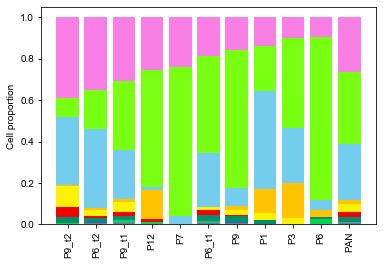

In [93]:
allcelldfr2 = allcelldfr.copy(deep=True)
allcellpdfr2 = allcellpdfr.copy(deep=True)
for pop, merge_l in merged_cellpops2.items():
    allcelldfr2 = allcelldfr2.append(pd.DataFrame(allcelldfr[allcelldfr.index.isin(merge_l)].sum()).rename(columns={0:pop}).T)
    allcellpdfr2 = allcellpdfr2.append(pd.DataFrame(allcellpdfr[allcellpdfr.index.isin(merge_l)].sum()).rename(columns={0:pop}).T)

allcelldfr2 = allcelldfr2[~allcelldfr2.index.isin(allrepes2)]
allcellpdfr2 = allcellpdfr2[~allcellpdfr2.index.isin(allrepes2)]

count = np.zeros(len(allcellpdfr2.columns))

allcellpdfr2 = allcellpdfr2.rename(columns={i:p for i,p in enumerate(labels)})
sorted_patients = [p for p in allcellpdfr2.T.sort_values(by='Cyt cells all', ascending=False).index.tolist() if p != 'PAN']
sorted_patients.append('PAN')
allcellpdfr2 = allcellpdfr2[sorted_patients]

for row in allcellpdfr2.reset_index().to_dict(orient='records'):
    x = 0
    for col in allcellpdfr2.columns:
        plt.bar(x,row[col],bottom=count[x],color=impop_colors[row['index']])
        count[x]+=row[col]
        x+=1
plt.xticks(range(0,x),allcellpdfr2.columns,rotation=90)
plt.ylabel('Cell proportion')
plt.xticks(rotation=90)
plt.show()

### Cell proportion changes across followup samples

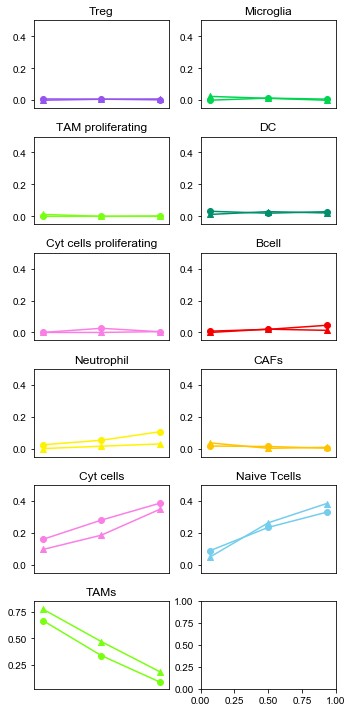

In [117]:
allcellpdfr = allcellpdfr.rename(columns={i:p for i,p in enumerate(labels)})

nrows = 15
fig,ax = plt.subplots(nrows=6,ncols=2,figsize=(5,10))
markers = ["^","o"]
i = 0
for s in ['P6','P9']:
    allcounts_persample_prop_sel = allcellpdfr[[c for c in allcellpdfr.columns if s in c]].reset_index()
    nrow = 0
    ncol = 0
    for row in allcounts_persample_prop_sel.to_dict(orient='records'):
        if ncol > 1:
            ncol = 0
            nrow +=1
        x = 0
        ys = []
        for c in [s,s+'_t1',s+'_t2']:
            if c !='index':
                ax[nrow,ncol].scatter(x,row[c],color=impop_colors[row['index']],marker=markers[i])
                x+=1
                ys.append(row[c])
        plt.sca(ax[nrow,ncol])
        plt.xticks([],[])
        plt.plot(range(0,x),ys,color=impop_colors[row['index']])
        plt.title(row['index'])

        if row['index']!='TAMs':
            plt.ylim(-0.05,0.5)

        ncol+=1
    i+=1
plt.tight_layout()
plt.show()